# **Mise en contexte**

A chaque date t,  
pour chaque allocation i,  
on doit prédire si le rendement futur RET(t+1) sera positif => problème de classification binaire (on n'estime pas la valeur du rendement mais la probabilité qu'il soit positif).

L'allocation est carctérisée par:

- Son Momentum (son passé recent) : colonnes RET_1 à RET_20, ses 20 derniers rendements journaliers

- Son Volume Signé (son empreinte sur le marché) : colonnes SIGNED_VOLUME_1 à SIGNED_VOLUME_20, force avec laquelle l'allocation a "poussé" le marché :
 - Si beaucoup d'odre d'achats => volume signé positif (pression acheteuse)
 - Si beaucoup d'odre de vente = > volume signé négatif (pression vendeuse)

- Son Turnover (sa nervosité) :  colonne MEDIAN_DAILY_TURNOVER, vitesse à laquelle l'allocation change ses positions (exemple : acheter et venrdre tous les journes => turnover elevé)

- Son Groupe (son appartenance) : colonne GROUP, sa famille (actions, obligations etc.)

# **Importations**

In [25]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# **Chargement des données**

X_train (les indices) : c'est le "passé", pour chaque allocation à une date donnée on a des informations (rendements, volumes etc).  
y_train (le corrigé) : c'est le "futur" par rapport à X_train, il contient la réponse (ce qui est reéellement arrivé le lendemain)

X_test : il ressemble exactement à X_train mais pour des dates plus récentes.  
On a pas y_test (le corrigé) => on doit le deviner.

sample_submission :  fichier vide qui contient la liste de tous les ROW_ID, et une colonne prédiction qui est à remplir avec:
- 0 : pari sur la BAISSE (on predit que le rendement sera negatif ou nul, on pense que l'allocation va perdre de l'argent, donc il vaudrait mieux parier contre elle)
- 1 : pari sur la HAUSSE (on predit un rendement positif, on fait confiance à l'allocation, on pense qu'elle va gagner de l'argent)

In [26]:
X_train = pd.read_csv('csv_files/X_train_9xQjqvZ.csv', index_col = 'ROW_ID')
X_test = pd.read_csv('csv_files/X_test_1zTtEnD.csv', index_col =  'ROW_ID')
y_train = pd.read_csv('csv_files/y_train_Ppwhaz8.csv', index_col =  'ROW_ID')

# **Nettoyage des données**

In [27]:
# Valeurs manquantes
print("Valeurs manquantes: \n")
print("X_train: \n", X_train.isnull().sum(), "\n")
print("X_test: \n", X_test.isnull().sum(), "\n")

# Valeurs dupliquées 
print("valeurs dupliquées: \n")
print("X_train: \n", X_train.duplicated().sum(), "\n")
print("X_test: \n", X_test.duplicated().sum(), "\n")

# Cohérence des tailles
print("Cohérence des tailles: \n")
print("X_train: \n", X_train.shape, "\n")
print("y_train: \n", y_train.shape, "\n")
print("X_test: \n", X_test.shape, "\n")
print("sample_submission: \n", X_test.shape, "\n")

# Types de variables (on verifie s'il n'y a pas object)
print("Types de variables: \n")
print("X_train: \n", X_train.dtypes, "\n")
print("X_test: \n", X_test.dtypes, "\n")

Valeurs manquantes: 

X_train: 
 TS                            0
ALLOCATION                    0
RET_20                       58
RET_19                       50
RET_18                       42
RET_17                       34
RET_16                       26
RET_15                       18
RET_14                       13
RET_13                        9
RET_12                        6
RET_11                        4
RET_10                        2
RET_9                         0
RET_8                         0
RET_7                         0
RET_6                         0
RET_5                         0
RET_4                         0
RET_3                         0
RET_2                         0
RET_1                         0
SIGNED_VOLUME_20           8498
SIGNED_VOLUME_19           3002
SIGNED_VOLUME_18            859
SIGNED_VOLUME_17             58
SIGNED_VOLUME_16             50
SIGNED_VOLUME_15             42
SIGNED_VOLUME_14             34
SIGNED_VOLUME_13             26
SIGNED_

**Valeurs manquantes:**  
X_train et X_test ont des valeurs manquantes pour les colonnes : SIGNED_VOLUME_k, RET_K et MEDIAN_DAILY_RETURN  
=> il faut combler les valeurs manquantes.

Problème majeur : (X_train) SIGNED-VOLUME 1 compte 387506 de valeurs manquantes ce qui correspond à + de 50% de la colonne.  
=> cette feature est inutilisable seule, il vaut mieux la supprimer.  

MEDIAN_DAILY_TURNOVER : etant donné que le turnover n'est jamais à 0 (car une allocation bouge toujours un peu), imputer à 0 serait une erreur. Ainsi, on impute à la médiane. 

SIGNED_VOLUME_k (k de 2 à20), RET_K : imputation à 0.

**Valeurs dupliquées:**  
X_train : 0  et X_test : 0  
=> rien à faire.

**Coherence des tailles:**  
X_train et y_train sont de la même taille.
X_test et sample_submission sont de la meille taille. 
=> rien à faire.

**Types de variables:** 
X_train et X_test ont des variables objects (TS et Allocation sont en object)  
=> il faut les convertir.

TS contient des chaînes de caractères au format DATE_XXXX, on va donc extraire le numéro de la date (XXXX).  
ALLOCATION est une variable catégoreille (identifiant d'allocation), il faut donc l'encoder : chaque identifiant textuel d'allocation devient une valeur numérique (ex ALLOCATION_01 devient 0).



In [28]:
# comme le modèle apprend sur X_train puis fera des prédictions sur X_test, 
# les deux datasets doivent avoir les mêmes colonnes, donc on fait les changements sur X_test aussi

## valeurs manquantes

# signed_volume_1
X_train =  X_train.drop(columns=['SIGNED_VOLUME_1'])
X_test = X_test.drop(columns=['SIGNED_VOLUME_1']) 

# median_daily_return, imputation à la médiane 
median_turnover = X_train['MEDIAN_DAILY_TURNOVER'].median()
X_train['MEDIAN_DAILY_TURNOVER'] = X_train['MEDIAN_DAILY_TURNOVER'].fillna(median_turnover)
X_test['MEDIAN_DAILY_TURNOVER'] = X_test['MEDIAN_DAILY_TURNOVER'].fillna(median_turnover)

# il reste seulement les valeurs manquantes de signed_volume_k (k allant de 2 à 20) et ret_k, imputztion à 0
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

## types de variables

# Conversion de TS & tri du dataset en fct de TS (du plus ancien au plus récent)
X_train['TS'] = X_train['TS'].str[5:].astype(int) # on enlève les 5 premiers caractères du texte puis on convertit en chiffre
X_test['TS'] = X_test['TS'].str[5:].astype(int)

X_train = X_train.sort_values('TS')
X_test = X_test.sort_values('TS')

# réalignement 
y_train = y_train.loc[X_train.index] # on doit modifer l'ordre de y train pour garder la correspondance ligne par ligne

# label encoding allocation
LE = LabelEncoder()

all_allocs = pd.concat([X_train['ALLOCATION'], X_test['ALLOCATION']]).unique() # on apprend tous les noms d'allocations possibles
LE.fit(all_allocs)

X_train['ALLOCATION'] = LE.transform(X_train['ALLOCATION']) # les textes sont maintenant remplacés par des numéros 
X_test['ALLOCATION'] = LE.transform(X_test['ALLOCATION'])

## verification
print("Valeurs manquantes: \n")
print("X_train: \n", X_train.isnull().sum(), "\n")
print("X_test: \n", X_test.isnull().sum(), "\n")
print("Types de variables: \n")
print("X_train: \n", X_train.dtypes, "\n")
print("X_test: \n", X_test.dtypes, "\n")

Valeurs manquantes: 

X_train: 
 TS                       0
ALLOCATION               0
RET_20                   0
RET_19                   0
RET_18                   0
RET_17                   0
RET_16                   0
RET_15                   0
RET_14                   0
RET_13                   0
RET_12                   0
RET_11                   0
RET_10                   0
RET_9                    0
RET_8                    0
RET_7                    0
RET_6                    0
RET_5                    0
RET_4                    0
RET_3                    0
RET_2                    0
RET_1                    0
SIGNED_VOLUME_20         0
SIGNED_VOLUME_19         0
SIGNED_VOLUME_18         0
SIGNED_VOLUME_17         0
SIGNED_VOLUME_16         0
SIGNED_VOLUME_15         0
SIGNED_VOLUME_14         0
SIGNED_VOLUME_13         0
SIGNED_VOLUME_12         0
SIGNED_VOLUME_11         0
SIGNED_VOLUME_10         0
SIGNED_VOLUME_9          0
SIGNED_VOLUME_8          0
SIGNED_VOLUME_7       

# **Split temporel**

Actuellement, nous avons un ensemble d'entrainement complet X_train (les questions) et y_train (les réponses). Mais, si l'on donne l'entièreté de ces données à notre modèle, on risque un overfitting (sur-apprentissage). Le modèle pourrait mémoriser les bruits du passé au lieu d'apprendre des règles généralisables, ce qui le rendrait inefficace sur le fichier X_test.  

Puisque nos données sont triés par TS, les premières lignes concernent le passé loitain et les dernières le passé récent. Nous allons donc nous entraîner sur les 80% premières lignes (set d'entraînement) et garder les 20% dernières (set de validation) pour voir si notre modèle est bon.

In [29]:
# création de la partie "Etude" (le passé)
split_index = int(len(X_train)*0.8)
X_train_splitted = X_train.iloc[:split_index]
y_train_splitted = y_train.iloc[:split_index]

# creation de la partie test (le futur proche)
X_validation = X_train.iloc[split_index:]
y_validation = y_train.iloc[split_index:]

# vérification (affiche la date la plus ancienne et la plus récente pour chaque bloc)
print(X_train_splitted["TS"].min(), X_train_splitted["TS"].max())
print(X_validation["TS"].min(), X_validation["TS"].max())


1 2013
2013 2522


Les sorties confirment la cohérence du split temporel : le jeu d'entraînement s'arrête au pas de temps 2013, tandis que le jeu de validation débute immédiatement après. 

# **Baseline**

Nous allons désormais entrâiner notre premier modèle (= La Baseline) pour obtenir un score de référence.

Nous avons décidé d'utiliser une Logistic Regression comme modèle de référence. Puisque nous travaillons sur une classification binaire (rendement futur POSITIF ou NON), la Logistic Regression est adaptée car elle estime directement une probabilité comprise entre 0 et 1. 

Pour rappel, après le split temporel, nous disposons de 2 sous-ensemble :
- une partie étude (passé) pour l'entrainement 
- une partie validation (futur proche) pour l'evaluation

Il faut donc préparer les données qui vont être réellement utilisées par le modèle. On retire les features qui ne servent pas à prédire (ici il s'agit de TS, ROW_ID étant l'index on a pas besoin de le drop) et on garde uniquement les variables explicatives décrivant l'allocation à la date t (rendement, volume signé, turnover, groupe), ce qui crée une nouvelle matrice X de features.

Concernant le résultat que l'on souhaite prédire, on crée un vecteur y contenant la colonne target (contenue dans bloc validation).

*Linear Regression*

In [30]:
# Préparation de la matrice de features et du vecteur target
X_tr = X_train_splitted.drop(columns=["TS"])
X_val = X_validation.drop(columns=["TS"])

y_tr = y_train_splitted["target"]
y_val = y_validation["target"]

# La colonne target contient actuellement des rendements bruts et non des valeurs binaires (classe 1 pour rendement positif, classe 0 pour rendement negatif),il faut donc la transformer
y_tr = (y_tr>0).astype(int) # si positif = TRUE = 1
y_val = (y_val>0).astype(int)

# standardisation
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)
X_val_scaled = scaler.transform(X_val)

# creation de la baseline
model = LogisticRegression(max_iter=1000, random_state=42)

# training (sur la partie Etude)
model.fit(X_tr_scaled, y_tr)

# calcul des probabilités pour l'AUC
#[:, 1] renvoie seulement la proba que la classe soit 1 ce qui correspond dans notre cas à un rendement futur positif 
#[:, 0] aurait renvoyé la proba que le rendement futur soit non positif
y_pred_proba = model.predict_proba(X_val_scaled)[:, 1] 

# calcul du score final (on compare ce qu'on a predit avec les vrais résultats)
auc_score = roc_auc_score(y_val, y_pred_proba)
print("AUC validation: ", auc_score)


AUC validation:  0.5251869931417594


Le modèle de réference affiche un score d'environ 0.5251, ce qui est à peine mieux que le hasard.  
 La pipeline est validée (structure technique foctionne sans erreur).  
 Le signal est faible : les données brutes sont trop bruitées pour prédire le futur directement.  
 
 L'étape suivante est le Features Engineering pour créer des indicateurs plus parlant et tenter d'améliorer la prédiction.

# **Feature Engineering**

L'objectif de cette étape est de transformer les variables brutes (les rendements, le volume signé etc) en indicateurs plus exploitables et interpétables pour le modèle. Par exemple, les colonnes RET_k contiennent les rendements journaliers passés de l'allocation et les colonnes SIGNED_VOLUME_K décrivent la pression acheteuse ou vendeuse récente. Ces infos sont riches mais très bruitées si on les utilise directement. On doit donc les structurer en mesurant:
- la dynamique passée (momentum) : on calcule la moy des rendements sur un periode donnée ce qui permet d'évaluer si la performance récente ets gloablement orientée à la hause ou à la baisse.
- la dispersion des rendements (volatilité) : on calcule l'ecart type des rendements sur une periode donnée, une volatilité elevée signifierait que les rendements sont instables et donc plus difficiles à prévoir.
- la persistance des flux directionnels : on calcule la moy pour évaluer la solidité du mouvement.

In [31]:
## momentum
# creation d'une colonne contenant la moyenne des 5 derniers rendements journaliers
X_train['RET_MEAN_5'] = X_train[['RET_1', 'RET_2', 'RET_3', 'RET_4', 'RET_5']].mean(axis=1) # on emt axis=1 acr c'est normalement axis=0 par defaut sauf qu'ici nos données sont organisées de manière horizontales (une ligne = une alloc à une date précise)## 
X_test['RET_MEAN_5'] = X_test[['RET_1', 'RET_2', 'RET_3', 'RET_4', 'RET_5']].mean(axis=1)

## volatilite
# creation d'une colonne contenant l'ecart-type des 5 derniers rendements journaliers
X_train['RET_STD_5'] = X_train[['RET_1', 'RET_2', 'RET_3', 'RET_4', 'RET_5']].std(axis=1)
X_test['RET_STD_5'] = X_test[['RET_1', 'RET_2', 'RET_3', 'RET_4', 'RET_5']].std(axis=1)

## Flux
# creation d'une colonne contenant la moyenne des 5 derniers volumes signés
X_train['SIGNED_VOLUME_MEAN_5'] = X_train[['SIGNED_VOLUME_2', 'SIGNED_VOLUME_3', 'SIGNED_VOLUME_4', 'SIGNED_VOLUME_5', 'SIGNED_VOLUME_6']].mean(axis=1) # un crochet = une seule colonne, double crochet = liste de colonnes
X_test['SIGNED_VOLUME_MEAN_5'] = X_test[['SIGNED_VOLUME_2', 'SIGNED_VOLUME_3', 'SIGNED_VOLUME_4', 'SIGNED_VOLUME_5', 'SIGNED_VOLUME_6']].mean(axis=1)


# on refait le split puisqu'on ajouté des nouvelles colonnes
X_train_splitted = X_train.iloc[:split_index]
y_train_splitted = y_train.iloc[:split_index]

X_validation = X_train.iloc[split_index:]
y_validation = y_train.iloc[split_index:]

# preparation de la matrice features et du vecteur target
X_tr = X_train_splitted.drop(columns=["TS"])
X_val = X_validation.drop(columns=["TS"])

y_tr = y_train_splitted["target"]
y_val = y_validation["target"]

y_tr= (y_tr >0).astype(int) # si positif = TRUE = 1
y_val = (y_val>0).astype(int)

scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)
X_val_scaled = scaler.transform(X_val)


model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_tr_scaled, y_tr)


y_pred_proba = model.predict_proba(X_val_scaled)[:, 1] 

auc_score = roc_auc_score(y_val, y_pred_proba)
print("AUC validation: ", auc_score)



AUC validation:  0.5240303121664949


AUC score en dessous de celui de la baseline : il faut passer à un autre modèle : le Random Forest.

*Random Forest*

depth = 3 AUC = 0.5270522536057051
depth = 6 AUC = 0.530053097021461
depth = 8 AUC = 0.5307545861228534


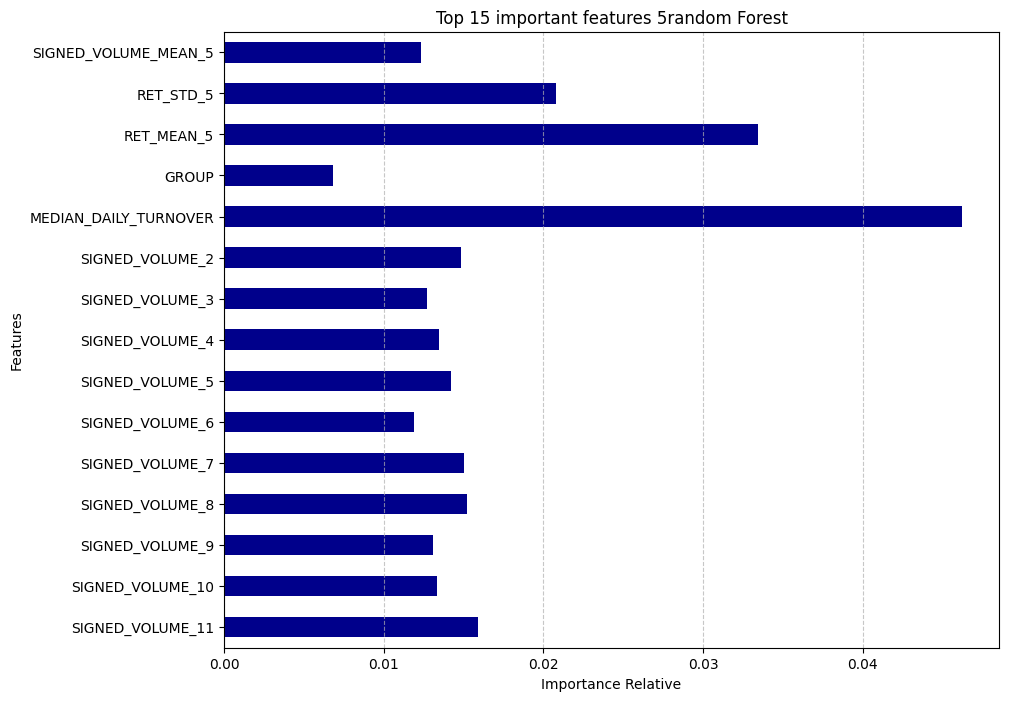

In [32]:
for depth in [3,6,8]:
    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=depth,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_tr, y_tr) # pas besoin de scaler pour le RF

    y_pred_proba = model.predict_proba(X_val)[:,1]

    auc_score = roc_auc_score(y_val, y_pred_proba)
    print("depth =", depth, "AUC =", auc_score)

# features importance
importances = model.feature_importances_
importances_df = pd.Series(importances, index = X_tr.columns) # creation d'un tableau où chaque score d'importance est associé au nom de sa colonne correspondante

plt.figure(figsize=(10,8))
importances_df.tail(15).plot(kind='barh', color='darkblue')
plt.title("Top 15 important features 5random Forest")
plt.xlabel("Importance Relative")
plt.ylabel("Features")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

RF  fait mieux que le Linear Regression (0.53>0.52) mais gain toujours très faible.
On va maintenant garder seulement les features importantes (MEDIAN_DAILY_TURNOVER, RET_MEAN_5, RET_STD_5) et comparer le score de prediction.

In [33]:
features = ['MEDIAN_DAILY_TURNOVER', 'RET_MEAN_5', 'RET_STD_5']

X_tr = X_tr[features]
X_val = X_val[features]

model = RandomForestClassifier(
        n_estimators=200,
        max_depth=8,
        random_state=42,
        n_jobs=-1
    )

model.fit(X_tr, y_tr) # pas besoin de scaler pour le RF

y_pred_proba = model.predict_proba(X_val)[:,1]

auc_score = roc_auc_score(y_val, y_pred_proba)

print("AUC: ", auc_score)

AUC:  0.5116342820258194


Visiblement, en supprimant tout le reste et en gardant que les 3 features les + importantes on a affaibli la diversité de la forêt. En effet, pour depth=8, avec le dataset complet on a 0.53 et en gardant que les 3 features importantes on obtient 0.51.


Nous allons essayer d'améliorer le feature engineering avec :
- Le Multi-Horizon (5,10,20 jours) : on teste plusieurs fenêtres, cour terme, moyen-terme, long-terme (momentum/vol)
- Le Ranking : on classe les allocations en fonction de la valeur de leur momentum, turnover  
- Interaction avec GROUP : les dynamiques peuvent différer selon la famille d'actifs, on introduit donc des interactions/rankings au sein des groupes

In [34]:
## MULTI-HORIZON

# 5jours, 10 jours, 20 jours 
ret_5  = ['RET_1','RET_2','RET_3','RET_4','RET_5']
ret_10 = ['RET_1','RET_2','RET_3','RET_4','RET_5','RET_6','RET_7','RET_8','RET_9','RET_10']
ret_20 = ['RET_1','RET_2','RET_3','RET_4','RET_5','RET_6','RET_7','RET_8','RET_9','RET_10',
          'RET_11','RET_12','RET_13','RET_14','RET_15','RET_16','RET_17','RET_18','RET_19','RET_20']

# momentum
X_train['RET_MEAN_5'] = X_train[ret_5].mean(axis=1)
X_train['RET_MEAN_10'] = X_train[ret_10].mean(axis=1)
X_train['RET_MEAN_20'] = X_train[ret_20].mean(axis=1)

X_test['RET_MEAN_5'] = X_test[ret_5].mean(axis=1)
X_test['RET_MEAN_10'] = X_test[ret_10].mean(axis=1)
X_test['RET_MEAN_20'] = X_test[ret_20].mean(axis=1)

# volatitlite
X_train['RET_STD_5'] = X_train[ret_5].std(axis=1)
X_train['RET_STD_10'] = X_train[ret_10].std(axis=1)
X_train['RET_STD_20'] = X_train[ret_20].std(axis=1)

X_test['RET_STD_5'] = X_test[ret_5].std(axis=1)
X_test  ['RET_STD_10'] = X_test[ret_10].std(axis=1)
X_test['RET_STD_20'] = X_test[ret_20].std(axis=1)

## RANKING

# découpe le DF en paquets séparés, un paquet par date TS. 
# on compare donc des allocations qui existent le mm jour 
# dans chaque paquet, on regarde une seule colonne : le momentum 5j
# dans chaque paquet n classe les allocs pa leur momentum
# pct = true convertit le rang en pourcentage 
X_train['RET_MEAN_5_RANK'] = X_train.groupby('TS')['RET_MEAN_5'].rank(pct=True) 
X_train['RET_MEAN_10_RANK'] = X_train.groupby('TS')['RET_MEAN_10'].rank(pct=True) 
X_train['RET_MEAN_20_RANK'] = X_train.groupby('TS')['RET_MEAN_20'].rank(pct=True) 

X_test['RET_MEAN_5_RANK'] = X_test.groupby('TS')['RET_MEAN_5'].rank(pct=True) 
X_test['RET_MEAN_10_RANK'] = X_test.groupby('TS')['RET_MEAN_10'].rank(pct=True) 
X_test['RET_MEAN_20_RANK'] = X_test.groupby('TS')['RET_MEAN_20'].rank(pct=True) 

X_train['TURNOVER_RANK']    = X_train.groupby('TS')['MEDIAN_DAILY_TURNOVER'].rank(pct=True)
X_test['TURNOVER_RANK']     = X_test.groupby('TS')['MEDIAN_DAILY_TURNOVER'].rank(pct=True)

## Interaction avec GROUP
# on regroupe par date et groupe    
X_train['RET_MEAN_5_RANK_GROUP'] = X_train.groupby(['TS', 'GROUP'])['RET_MEAN_5'].rank(pct=True)
X_test['RET_MEAN_5_RANK_GROUP']  = X_test.groupby(['TS','GROUP'])['RET_MEAN_5'].rank(pct=True)

# tests
features_horizon = ['RET_MEAN_5','RET_MEAN_10','RET_MEAN_20','RET_STD_5','RET_STD_10','RET_STD_20','MEDIAN_DAILY_TURNOVER']
features_rank= ['RET_MEAN_5_RANK','RET_MEAN_10_RANK', 'RET_MEAN_20_RANK', 'TURNOVER_RANK', 'RET_MEAN_5_RANK_GROUP']
features_mixed = features_rank + ['RET_STD_20']

# on refait le split puisqu'on ajouté des nouvelles colonnes
X_train_splitted = X_train.iloc[:split_index]
y_train_splitted = y_train.iloc[:split_index]

X_validation = X_train.iloc[split_index:]
y_validation = y_train.iloc[split_index:]

# preparation de la matrice features et du vecteur target
X_tr = X_train_splitted.drop(columns=["TS"])
X_val = X_validation.drop(columns=["TS"])

y_tr = y_train_splitted["target"]
y_val = y_validation["target"]

y_tr = (y_tr>0).astype(int) # si positif = TRUE = 1
y_val = (y_val>0).astype(int)


def test_rf(features, max_depth=8):
    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=max_depth,
        random_state=42,
        n_jobs=-1
    ) 
    
    model.fit(X_tr[features], y_tr)
    y_pred_proba = model.predict_proba(X_val[features])[:,1]
    return roc_auc_score(y_val, y_pred_proba)

score_horizon = test_rf(features_horizon)
score_rank = test_rf(features_rank)
score_mixed = test_rf(features_mixed)

# toutes les features 
model = RandomForestClassifier(
        n_estimators=200,
        max_depth=8,
        random_state=42,
        n_jobs=-1
    )

model.fit(X_tr, y_tr) # pas besoin de scaler pour le RF

y_pred_proba = model.predict_proba(X_val)[:,1]

score_all = roc_auc_score(y_val, y_pred_proba)

print("AUC horizon only:", score_horizon)
print("AUC rank only:", score_rank)
print("AUC mix:", score_mixed)
print("AUC all: ", score_all)

AUC horizon only: 0.5172715762794905
AUC rank only: 0.5146912262505257
AUC mix: 0.5171299578869658
AUC all:  0.5336313444280095


Nouvelles features seules => faible
Mais ajoutée aux features brutes => légère amélioration du modèle 

Après avoir stabilisé notre pipeline et amélioré le feature engineering, nous obtenons un score d’environ 0.53 avec un Random Forest.

Nous testons désormais un modèle de Gradient Boosting (XGBoost) afin d’évaluer si une méthode plus puissante et plus flexible permet d’exploiter plus efficacement le signal existant.

# **XGBoost**

In [35]:
model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

model.fit(X_tr, y_tr)

y_pred_proba_xgb =model.predict_proba(X_val,)[:,1]
auc_score = roc_auc_score(y_val, y_pred_proba_xgb)

print("AUC: ", auc_score)

AUC:  0.5286533534982182


# **Entraînement final sur 100% des données**

In [36]:
features_finales = X_tr.columns.tolist()
y_tr = y_train["target"]

model_final = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42, n_jobs=-1)
model_final.fit(X_train[features_finales], (y_tr > 0).astype(int))

X_test_final = X_test[features_finales].drop(columns=["TS"], errors='ignore')
y_test_pred = model_final.predict_proba(X_test_final)[:, 1]

# si proba > 0.5 alors 1, sinon 0
y_test_pred_bin = (y_test_pred > 0.5).astype(int)

submission = pd.DataFrame({
    'ROW_ID': X_test.index,
    'prediction': y_test_pred_bin
})

submission = submission.sort_values(by='ROW_ID')

submission.to_csv('outputs/submission.csv', index=False)
